In [ ]:
import pandas as pd 

import matplotlib.pyplot as plt
import scikitplot as skplt


from sklearn import metrics
from sklearn.model_selection import train_test_split

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import sys
sys.path.append('../../data/')
import cleaner as dc

In [3]:
df = pd.read_csv('data/persuasion_dataset.csv') 
df.shape

(13114, 2)

In [5]:
# Lower case
df['ad']= df['ad'].apply(lambda x: x.lower())

# Removing punctuations
df['ad']= df['ad'].str.replace('[^\w\s]','', regex=True)

# Removing numbers
df['ad']= df['ad'].str.replace('\d+','',regex=True)

# Removing extra space 
df['ad']= df['ad'].str.replace('\s+', ' ',  regex=True)

#Apply denoise function
df['ad']= df['ad'].apply(dc.denoise_text)

##Remove stopwords 
df['ad']= df['ad'].apply(dc.remove_stopwords)

#Remove special characters
df['ad']= df['ad'].apply(dc.remove_special_characters)

#Simple stemming 
df['lemmatized']= df['ad'].apply(dc.simple_lemmatizer)

In [6]:
norm_train, norm_test,  y_train, y_test= train_test_split(df['lemmatized'], df['label'], test_size =0.2, random_state=42)

: 

In [7]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('isignificantly', 28026), ('<PAD>', 0), 1)

In [8]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [9]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((10491, 1000), (2623, 1000))

In [10]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a 
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional global max pooling layer  
            - A fully connected layer with specified number of units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [11]:
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 128
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         3587456   
                                                                 
 dropout (Dropout)           (None, 1000, 128)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [13]:
# Train the neural net and evaluate results 
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/5
296/296 [==============================] - 20s 65ms/step - loss: 0.4496 - accuracy: 0.8190 - val_loss: 0.2214 - val_accuracy: 0.9248
Epoch 2/5
296/296 [==============================] - 19s 65ms/step - loss: 0.1435 - accuracy: 0.9518 - val_loss: 0.1471 - val_accuracy: 0.9390
Epoch 3/5
296/296 [==============================] - 20s 67ms/step - loss: 0.0705 - accuracy: 0.9803 - val_loss: 0.1266 - val_accuracy: 0.9457
Epoch 4/5
296/296 [==============================] - 19s 65ms/step - loss: 0.0377 - accuracy: 0.9907 - val_loss: 0.1253 - val_accuracy: 0.9448
Epoch 5/5
296/296 [==============================] - 21s 72ms/step - loss: 0.0202 - accuracy: 0.9968 - val_loss: 0.1254 - val_accuracy: 0.9495


In [14]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

82/82 [==============================] - 0s 5ms/step - loss: 0.1186 - accuracy: 0.9508
Accuracy: 95.08%


In [15]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

82/82 [==============================] - 0s 5ms/step


[1, 0, 0, 1, 1, 0, 0, 1, 1, 0]

                precision    recall  f1-score   support

no-persusasion       0.95      0.95      0.95      1314
    persuasion       0.95      0.95      0.95      1309

      accuracy                           0.95      2623
     macro avg       0.95      0.95      0.95      2623
  weighted avg       0.95      0.95      0.95      2623

confusion matrix:
[[1249   65]
 [  64 1245]]



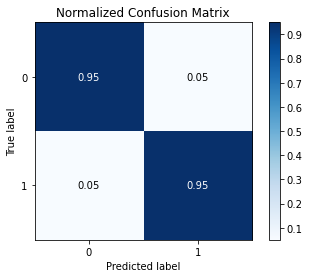

In [17]:
print(metrics.classification_report(y_test, predictions, target_names=[ 'no-persusasion', 'persuasion']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

10/10 [==============================] - 0s 5ms/step
Accuracy: 77.43%
confusion matrix:
[[ 34  58]
 [ 14 213]]



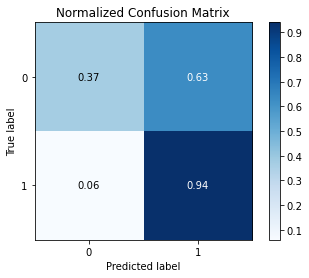

In [18]:
save = pd.read_csv('sample_persuasion_cleaned.csv')

norm_ = save['text_lemmatized']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

pred_ = model.predict(padded_)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

scores = model.evaluate(padded_, save['label'], verbose =False)
print("Accuracy: %.2f%%" % (scores[1]*100))

print("confusion matrix:")
print(metrics.confusion_matrix(save['label'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['label'], save['predicted'], normalize=True)
plt.show()

In [19]:
print(metrics.classification_report(save['label'],save['predicted'], target_names=[ 'no-persuasive', 'persuasive']))

               precision    recall  f1-score   support

no-persuasive       0.71      0.37      0.49        92
   persuasive       0.79      0.94      0.86       227

     accuracy                           0.77       319
    macro avg       0.75      0.65      0.67       319
 weighted avg       0.76      0.77      0.75       319

